In [ ]:
!pip install comet_ml --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.7/655.7 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 71.5 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.1.1
    Uninstalling python-box-7.1.1:
      Successfully uninstalled python-box-7.1.1


In [ ]:
from comet_ml import Experiment
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
experiment = Experiment(
    api_key= "TLz1bKUwBaog2a5ZQxpSZrCoB",
    project_name="testproject-cc",
    workspace="dlipr-kuo-tanveer-wieland",
    display_summary_level = 0
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/dlipr-kuo-tanveer-wieland/testproject-cc/912b5e2498e443a8bd00527c198df80e



## Data

In [ ]:
(x_data, y_data), (x_test, y_test) = keras.datasets.cifar10.load_data()
Y_data = keras.utils.to_categorical(y_data, 10) #shape:(50000, 10)
Y_test = keras.utils.to_categorical(y_test, 10) #shape:(10000, 10)
n_split = int(50000 * 0.9)
X_train = x_data[:n_split,:,:,:]
X_valid = x_data[n_split:,:,:,:]
Y_train = Y_data[:n_split,:]
Y_valid = Y_data[n_split:,:]

x_train (45000, 32, 32, 3)
y_train (45000, 10)
x_valid (5000, 32, 32, 3)
y_valid (5000, 10)
x_test (10000, 32, 32, 3)
y_test (10000, 10)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


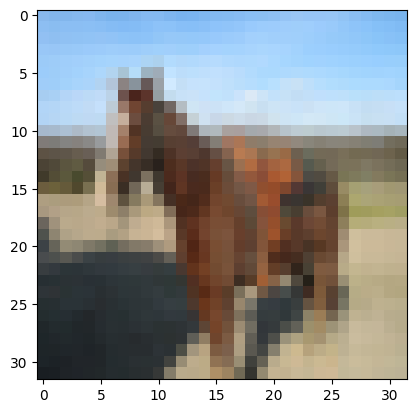

In [ ]:
print("x_train",np.shape(X_train))
print("y_train",np.shape(Y_train))
print("x_valid",np.shape(X_valid))
print("y_valid",np.shape(Y_valid))
print("x_test",np.shape(x_test))
print("y_test",np.shape(Y_test))

No_data = 888
print(Y_valid[No_data,:])
plt.imshow(X_valid[No_data,:,:,:])

In [ ]:
models = keras.models
lay = keras.layers
regularizers = keras.regularizers
image = keras.preprocessing.image

## DenseNet

In [ ]:
def conv_block(x, filters, drop=0, decay=1e-4, name="conv"):
    """Apply BatchNorm, ReLU, Conv2D and (optionally) Dropout.

    # Arguments
        x: Input Keras tensor
        filters: number of convolution filters
        drop: dropout fraction
        decay: weight decay factor

    # Returns
        Keras tensor after the convolution block.
    """

    x = lay.Conv2D(
        filters,
        (3, 3),
        padding="same",
        use_bias=False,
        kernel_initializer="he_uniform",
        kernel_regularizer=regularizers.l2(decay),
        name=name + "_conv2D",
    )(x)
    x = lay.Activation("relu", name=name + "_relu")(x)
    if drop:
        x = lay.Dropout(drop)(x)
    return x


def dense_block(x, num_layers, filters, drop=0, decay=1e-4, name="dense"):
    """Build a dense_block where each layer is connected to all subsequent layers.

    # Arguments
        x: Keras tensor
        num_layers: the number of convolution_layers in the dense block
        filters: number of extra filters in each subsequent convolution
        drop: dropout fraction
        decay: weight decay factor

    # Returns:
        Keras tensor after the dense block.
    """
    xl = [x]
    for i in range(num_layers):
        _name = "%s_%i" % (name, i + 1)
        x = conv_block(x, filters, drop=drop, decay=decay, name=_name)
        xl.append(x)
        x = lay.concatenate(xl[:], axis=-1, name=_name + "_concat")
    return x


def transition_block(x, filters, drop=None, decay=1e-4, name="transition"):
    """Apply BatchNorm, ReLU, 1x1 Conv2D, Dropout and Maxpooling2D

    # Arguments
        x: Keras tensor
        filters: number of filters
        drop: dropout fraction
        decay: weight decay factor

    # Returns
        Keras tensor after the transition block
    """

    x = lay.Conv2D(
        int(filters),
        (1, 1),
        padding="same",
        use_bias=False,
        kernel_initializer="he_uniform",
        kernel_regularizer=regularizers.l2(decay),
        name=name + "_1x1conv",
    )(x)
    x = lay.Activation("relu", name=name + "_relu")(x)
    if drop:
        x = lay.Dropout(drop)(x)
    x = lay.AveragePooling2D((2, 2), strides=(2, 2), name=name + "_2x2pooling")(x)
    return x


def DenseNet(
    input_shape=(32, 32, 3),
    num_classes=10,
    dense=3,
    layers=[12],
    growth=12,
    filters=16,
    bottleneck=False,
    compression=1,
    drop=0,
    decay=1e-4,
):
    """
    Build the DenseNet model

    # Arguments
        input_shape: tuple of shape (channels, rows, columns) or (rows, columns, channels)
        num_classes: number of classes
        dense: number of dense blocks (default 3)
        layers: number of convolution layers per dense block
        growth: number of filters k to add per convolution
        filters: initial number of filters (default 16)
        bottleneck: not implemented
        compression: compression factor of transition blocks (0 - 1)
        drop: dropout fraction
        decay: weight decay

    # Returns
        A Keras model
    """
    x0 = lay.Input(shape=input_shape, name="input")

    # initial convolution
    x = lay.Conv2D(
        filters,
        (3, 3),
        padding="same",
        use_bias=False,
        kernel_initializer="he_uniform",
        kernel_regularizer=regularizers.l2(decay),
        name="initial_conv",
    )(x0)
    x = lay.Activation("relu", name="init_relu")(x)

    for i in range(dense):
        # add dense block
        x = dense_block(
            x, layers[i], growth, drop=drop, decay=decay, name="dense_%i" % (i + 1)
        )

        # update the number of filters
        filters += layers[i] * growth
        filters = int(filters * compression)

        # add transition_block, except after last dense_block
        if i < (dense - 1):
            x = transition_block(
                x, filters, drop=drop, decay=decay, name="transition_%i" % (i + 1)
            )

    x = lay.GlobalAveragePooling2D(name="final_globalpooling")(x)

    # classification layer
    x = lay.Dense(
        num_classes,
        kernel_regularizer=regularizers.l2(decay),
        bias_regularizer=regularizers.l2(decay),
        activation="softmax",
        name="classification",
    )(x)

    return models.Model(inputs=[x0], outputs=[x], name="DenseNet")

## Training

In [ ]:
# -----------------------------------------
# Model and training
# -----------------------------------------
model = DenseNet(
    dense=4,
    layers=[6,12,36,48],
    growth=32,
    filters=16,
    bottleneck=False,
    compression=0.8,
    drop=0.3,
    decay=1e-4,)
# model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# data augmentation
generator = image.ImageDataGenerator(
    width_shift_range=4.0 / 32,
    height_shift_range=4.0 / 32,
    fill_mode="constant",
    horizontal_flip=True,
)
model_path = "./drive/MyDrive/Deep Learning in Physics Research/cf10_ckp.weights.h5"
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=10)
mcp_save = keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy')
# fit using augmented data
model.fit_generator(
    generator.flow(X_train, Y_train, batch_size=128),
    steps_per_epoch=len(X_train) // 128,
    validation_data=(X_valid, Y_valid),
    epochs=300,
    verbose=2,
    callbacks=[early_stop, mcp_save]
)

model.save("./drive/MyDrive/Deep Learning in Physics Research/cf10_model.h5")

Epoch 1/300
351/351 - 96s - loss: 5683.4482 - accuracy: 0.1594 - val_loss: 3.3036 - val_accuracy: 0.1994 - 96s/epoch - 273ms/step
Epoch 2/300
351/351 - 40s - loss: 3.1643 - accuracy: 0.2465 - val_loss: 3.7749 - val_accuracy: 0.1770 - 40s/epoch - 113ms/step
Epoch 3/300
351/351 - 46s - loss: 3.0345 - accuracy: 0.2967 - val_loss: 3.6504 - val_accuracy: 0.2074 - 46s/epoch - 130ms/step
Epoch 4/300
351/351 - 46s - loss: 2.9210 - accuracy: 0.3366 - val_loss: 4.1443 - val_accuracy: 0.2098 - 46s/epoch - 130ms/step
Epoch 5/300
351/351 - 45s - loss: 2.8432 - accuracy: 0.3634 - val_loss: 3.5865 - val_accuracy: 0.2310 - 45s/epoch - 129ms/step
Epoch 6/300
351/351 - 45s - loss: 2.7726 - accuracy: 0.3851 - val_loss: 3.3177 - val_accuracy: 0.3050 - 45s/epoch - 128ms/step
Epoch 7/300
351/351 - 39s - loss: 2.7070 - accuracy: 0.4025 - val_loss: 3.6323 - val_accuracy: 0.2688 - 39s/epoch - 112ms/step
Epoch 8/300
351/351 - 45s - loss: 2.6470 - accuracy: 0.4194 - val_loss: 3.2362 - val_accuracy: 0.3214 - 45s/

In [ ]:
model = models.load_model("./drive/MyDrive/Deep Learning in Physics Research/cf10_ckp.weights.h5")
[pred_loss, pred_accuracy] = model.evaluate(x_test, Y_test, verbose=0)

print("pred_loss",pred_loss)
print("pred_accuracy",pred_accuracy)

pred_loss 0.6815111041069031
pred_accuracy 0.8781999945640564


In [ ]:
y_pred = model.predict(x_test)

313/313 [==============================] - 6s 15ms/step


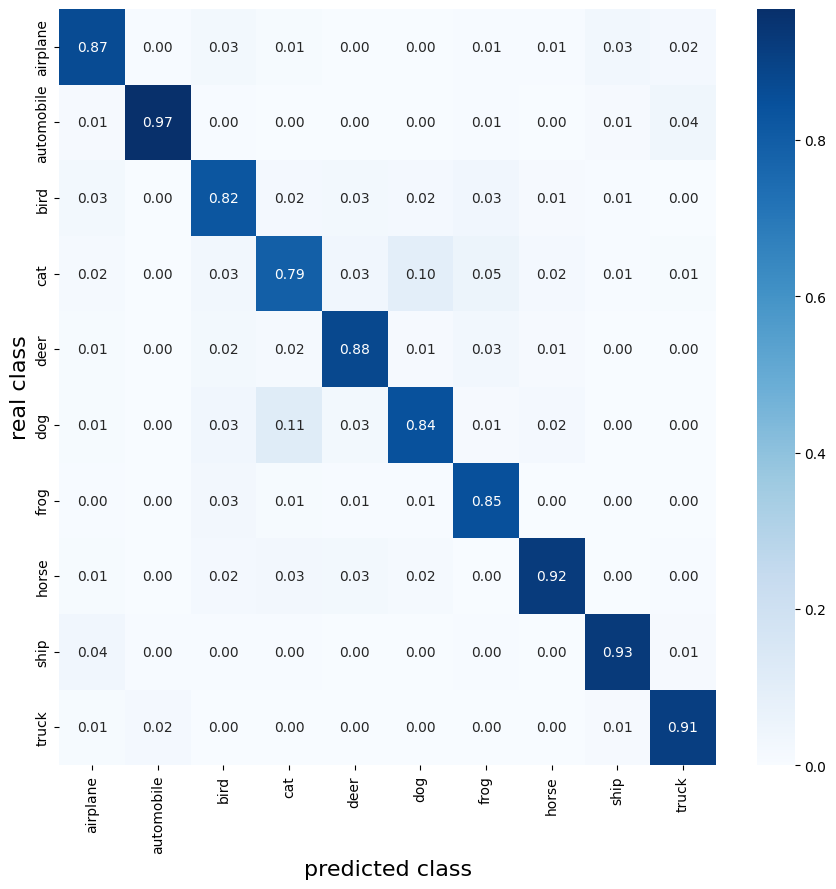

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

conv_mat = confusion_matrix(y_test, np.argmax(y_pred, axis = 1) , normalize='pred')
cats = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
df_cm = pd.DataFrame(conv_mat, index = [i for i in ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]],
                  columns = [i for i in ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]])
fig, ax = plt.subplots(figsize =(9,9))
# ax.imshow(conv_mat, cmap = "Blues")
# for i in range(conv_mat.shape[0]):
#     for j in range(conv_mat.shape[1]):
#         text = plt.text(j, i, round(conv_mat[i, j],2),
#                         ha="center", va="center", color="black")
sns.heatmap(df_cm, annot=True, cmap = "Blues", fmt='.2f')
plt.ylabel("real class", fontsize = 16)
plt.xlabel("predicted class", fontsize = 16)
# ax.xticks(range(len(cats)), cats, size='small')
# ax.yticks(range(len(cats)), cats, size='small')
# ax.xaxis.tick_top()


plt.tight_layout()
plt.savefig("conf_mat.png")
experiment.log_image("conf_mat.png")
plt.show()

In [ ]:
experiment.end()